## Final Project, Part 1: *Proposal*

1. Draft a well-formed problem statement relevant to a business problem affecting your team, division, or organization.
2. Include the following elements:
   - Hypothesis/assumptions
   - Goals and success metrics
   - Risks or limitations
3. Identify at least one relevant internal dataset and confirm that you have (or can get) the right access permissions.

- Original dataset from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T
- Kaggle dataset and competition from https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000/home
- Scientific paper from https://arxiv.org/abs/1803.10417


**null hypothesis:** There is no difference between dermatoscopic images of pigmented skin lesions between skin cancer diagnostic categories.

**alternative hypothesis:** There is a difference between dermatoscopic images of pigmented skin lesions between skin cancer diagnostic categories.

**goals and success:** Correctly classify dermatoscoptic images of pigmented skin lesions into a skin cancer diagnostic category at a probability higher than chance. There are 7 categories, so success metric would need to be 15% or greater.

**risks or limitations:** Requires enough sample data in each diagnostic category. Also required enough similarities of images within diagnostic category as well as distinctions between diagnostic categories.

## Final Project, Part 2: *Brief*

Exploratory data analysis is a crucial step in any data workflow. Create a Jupyter Notebook that explores your data mathematically and visually. Explore features, apply descriptive statistics, look at distributions, and determine how to handle sampling or any missing values.

1. Create an exploratory data analysis notebook.
2. Perform statistical analysis, along with any visualizations.
3. Determine how to handle sampling or missing values.
4. Clearly identify shortcomings, assumptions, and next steps.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

ham_df = pd.read_csv("./data/HAM10000_metadata.csv")

In [ ]:
display(ham_df.shape)
display(ham_df.head())
display(ham_df.describe(include="all"))
display(ham_df.dtypes)

- The HAM metadata has 10015 rows and 7 columns
- There are 7470 lesions, however, some are taken with different magnification and angles resulting in 10,015 images accoridng to the paper. This serves as natural data augmentation
- The 7 unique `dx` suggests we are classifying for multiple diseases and not binary classification

In [ ]:
print("Null values: \n", ham_df.isnull().sum())

In [ ]:
age_null = ham_df[ham_df['age'].isnull()]
age_null.head()

- Although there are NaN and unknown values for patient information. I propose we do not replace or drop values as I am considering not using them as features. These variables serve to show the distribution of data.
- The feature would be the images themselves.
- This is despite distribution of diagnoses varying with patient information.
    - eg. melanoma on areas not exposed to sun (incidence higher in leg for women and back for men) as opposed to akiec (actinic keratoses on face and Bowen's disease in other areas)

In [ ]:
print("Percentage distribution of target diagnostic values: \n", round(ham_df['dx'].value_counts(normalize=True)*100, 2))

variables = ['dx', 'dx_type', 'age', 'sex', 'localization']
for var in variables:
    ham_df[var].value_counts().plot(kind="bar")
    plt.title(var)
    plt.show();

ham_df['age'].plot(kind="hist", bins=15)
plt.title("age")
plt.show();

- `dx`
    - mostly nv (Melanocytic nevi) as these are benign/non-cancerous
    - much less sample data for the others
        - need to ensure there are enough sample data to include smaller categories
        - when modelling need to consider techniques such as oversampling, stratified folds
- `dx_type`
    - will be accepting all forms of diagnosis as accurate and not just histogram
- `localization`
    - in reality, these would vary by `dx` and `sex`
    
- Target value is `dx_type`

<img src="dx_samples.png" alt="Diagnostic category samples" title="Diagnostic category samples"/>
- From the images we can see that there are visual differences within categories
    - this is because they are categorised by biology
    - for example, `vasc` includes angiomas, angioketaomas, pyogenic granulomas and haemorrahge and therefore presentations may vary
    - in `blk`, a subset within (linchen-planus like keratoses) have features that are similar to `mel` and therefore ML may incorrectly classify these scenarios

**Next Steps**
- load and process data into `ham_df`
- use `hmnist` file and/or learn how images can be processed into data
- test train split
- start with a simple model
- read and find out what models are available and test these
- explore errors

## Final Project, Part 3: *Technical Notebook*

Develop a prototype model or process to successfully resolve the business problem you've chosen. Document your work in a technical notebook that can be shared with your peers.

Build upon your earlier analysis, folling the performance metrics you established as part of your problem's evaluation criteria. Demonstrate your approach logically, including all relevant code and data. Polish your notebook for peer audiences by cleanly formatting sections, headers, and descriptions in markdown. Include comments in any code.

1. A detailed Jupyter Notebook with a summary of your analysis, approach, and evaluation metrics.
2. Clearly formatted structure with section headings and markdown descriptions.
3. Comments explaining your code.

## (i) Organising the data

In [ ]:
from glob import glob
import os 
import shutil
import pandas as pd

ham_df = pd.read_csv("./data/HAM10000_metadata.csv")

In [ ]:
# Credit to Kevin Mader for this code
base_skin_dir = os.path.join(".", "data")

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, "*", "*.jpg"))}

ham_df['path'] = ham_df['image_id'].map(imageid_path_dict.get)

In [ ]:
# Placing label (diagnosis) into the name of image file
for dx, filename in zip(ham_df['dx'], ham_df['path']):
    path = filename[0:30]
    image_id = filename[-12:]
    os.rename(filename, path+dx+image_id)

In [ ]:
# Path where the image files are currently stored
path_1 = "./data/HAM10000_images_part_1"
path_2 = "./data/HAM10000_images_part_2"

# Create a new directory to store all images together
os.mkdir("./data/images/")

# Function to copy files to this image directory
def copy_files(path):
    src_files = os.listdir(path)
    for filename in src_files:
        full_filename = os.path.join(path, filename)
        if (os.path.isfile(full_filename)):
            shutil.copy(full_filename, "./data/images/"+filename)
   
move_files(path_1)
move_files(path_2)

In [ ]:
# Create a new directory to store some images
path_img = "./data/images"
os.mkdir("./data/test_images/")

# Function to move files to this test directory
def move_files(dx, repeat):
    src_files=os.listdir(path_img)
    i = 0
    dx = [filename for filename in src_files if dx in filename]
    for i in range(repeat):
        filename = dx[i]
        full_filename = os.path.join(path_img, filename)
        shutil.move(full_filename, "./data/test_images/"+filename)

# Set aside these images for testing at the end
move_files("akiec", 3)
move_files("bcc", 2)
move_files("bkl", 2)
move_files("df", 2)
move_files("mel", 2)
move_files("nv", 2)
move_files("vasc", 2)

## (ii) Deep learning

In [1]:
from fastai.vision import *
from fastai.metrics import error_rate
import re
import numpy as np
import matplotlib.pyplot as plt

# !curl https://course.fast.ai/setup/colab | bash
%reload_ext_autoreload
%autoreload 2
%matplotlib inline

UsageError: Line magic function `%reload_ext_autoreload` not found.


In [2]:
path_img = "./data/images/"
fnames = get_image_files(path_img)                  # grabs array of image files

np.random.seed(42)                                  # sets same validation set

# These are the data augmentations we'll be using (regularisation)
tfms = get_transforms(flip_vert=True,               # 8 symmetric dihedral rots/flips
                      max_rotate=20,                # rotate degrees
                      max_zoom=1.1,                 # zoom
                      max_lighting=0.3,             # lightin and contrast
                      max_warp=0.3,                 # magnitude of warp
                      p_affine=.9,                  # prob of applying affine and warp
                      p_lighting=.5)                # prob of applying lighting

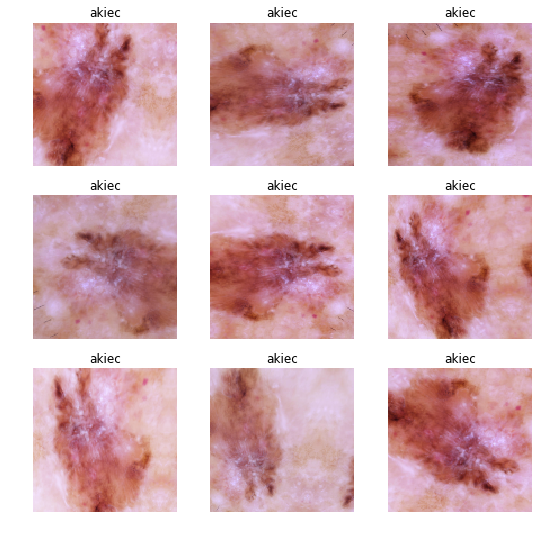

In [3]:
src = ImageItemList.from_folder(path_img).random_split_by_pct(0.2, seed=42)

regex = r'([^/]+)_\d+.jpg$'                         # regex
pat = re.compile(regex)

# We want to visualise these augmentations to ensure they look reasonable
get_data = (src.label_from_re(regex)
           .transform(tfms, size=128)
           .databunch(bs=64).normalize(imagenet_stats))

def _plot(i,j,ax):
    x, y = get_data.train_ds[211]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(9,9))
plt.savefig("akiec_augmentations.png")

In [4]:
# Data bunch contains train and validation
data = ImageDataBunch.from_name_re(path_img,        # path with images
                                   fnames,          # filenames
                                   pat,             # regex
                                   valid_pct=0.2,   # randomly sets aside 20% for validation
                                   ds_tfms=tfms,    # data augmentation
                                   size=128,        # image size
                                   bs=64)           # value depends on gpu
data.normalize(imagenet_stats)                      # pixel values of RGB to have mean 0 and std 1

# print("With our split, there are {0} train images and {1} validation images."
#       .format(len(data.train_ds), len(data.valid_ds)))

ImageDataBunch;

Train: LabelList
y: CategoryList (8000 items)
[Category nv, Category nv, Category nv, Category nv, Category nv]...
Path: data/images
x: ImageItemList (8000 items)
[Image (3, 450, 600), Image (3, 450, 600), Image (3, 450, 600), Image (3, 450, 600), Image (3, 450, 600)]...
Path: data/images;

Valid: LabelList
y: CategoryList (2000 items)
[Category nv, Category mel, Category nv, Category nv, Category akiec]...
Path: data/images
x: ImageItemList (2000 items)
[Image (3, 450, 600), Image (3, 450, 600), Image (3, 450, 600), Image (3, 450, 600), Image (3, 450, 600)]...
Path: data/images;

Test: None

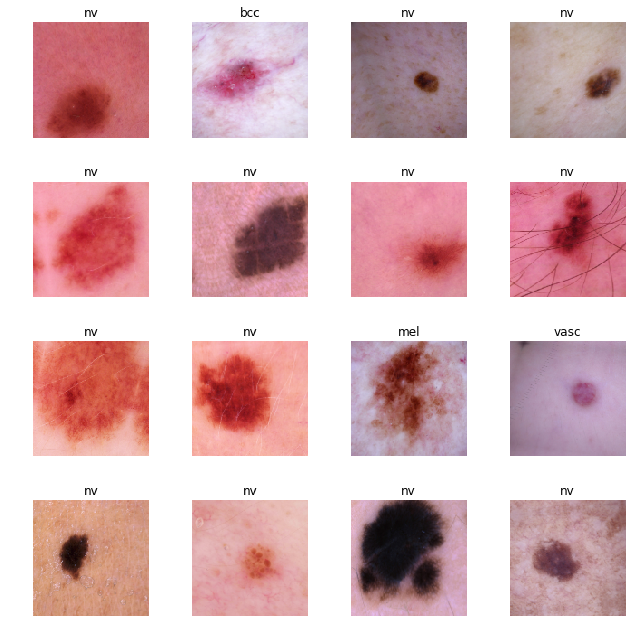

In [5]:
data.classes                                        # there are 7 classes (labels)
data.show_batch(rows=4, figsize=(9,9))              # show some contents

In [6]:
# Create convolutional neural net with pretrained weights from imagenet
learn = create_cnn(data, 
                   models.resnet50,                 # architecture
                   metrics=accuracy)                # against val set
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


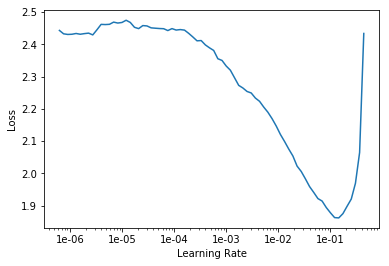

In [7]:
learn.lr_find()                                     # learning rate finder
learn.recorder.plot()

In [8]:
lr = 1e-2/2                                         # using largest downward slope
learn.fit_one_cycle(15, slice(lr))

# epoch	train_loss	valid_loss	accuracy
# 1	1.413054	0.918960	0.728000
# 2	0.933472	0.656341	0.765500
# 3	0.740995	0.611391	0.773500
# 4	0.690045	0.578866	0.785000
# 5	0.658273	0.551198	0.794000
# 6	0.604795	0.501787	0.819500
# 7	0.594263	0.493389	0.818500
# 8	0.546910	0.463592	0.830500
# 9	0.522979	0.467742	0.829000
# 10	0.483877	0.455677	0.840500
# 11	0.471069	0.457666	0.831000
# 12	0.445319	0.432772	0.843000
# 13	0.428453	0.435945	0.840500
# 14	0.434763	0.428247	0.843500
# 15	0.420740	0.424410	0.843500

epoch,train_loss,valid_loss,accuracy
1,1.413054,0.918960,0.728000
2,0.933472,0.656341,0.765500
3,0.740995,0.611391,0.773500
4,0.690045,0.578866,0.785000
5,0.658273,0.551198,0.794000
6,0.604795,0.501787,0.819500
7,0.594263,0.493389,0.818500
8,0.546910,0.463592,0.830500
9,0.522979,0.467742,0.829000
10,0.483877,0.455677,0.840500


In [9]:
learn.save("stage-1-resnet50-128")                  # save weights
learn.unfreeze()                                    # unfreeze so we can train the whole model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


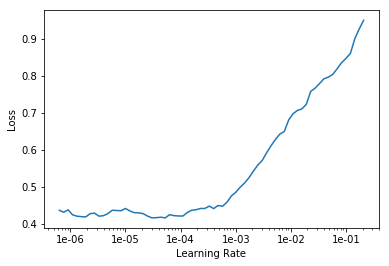

In [10]:
learn.lr_find()
learn.recorder.plot()                               # before it goes up

In [11]:
learn.fit_one_cycle(5, slice(1e-4/2, lr/10))

# epoch	train_loss	valid_loss	accuracy
# 1	0.466263	0.473510	0.833500
# 2	0.507958	0.452003	0.842000
# 3	0.430753	0.404824	0.852000
# 4	0.371470	0.348856	0.875000
# 5	0.295102	0.343722	0.875500

epoch,train_loss,valid_loss,accuracy
1,0.466263,0.473510,0.833500
2,0.507958,0.452003,0.842000
3,0.430753,0.404824,0.852000
4,0.371470,0.348856,0.875000
5,0.295102,0.343722,0.875500


In [12]:
learn.save("stage-2-resnet50-128")

In [13]:
# Repeat above with larger image size - progressive resizing
data = ImageDataBunch.from_name_re(path_img, 
                                   fnames, 
                                   pat, 
                                   valid_pct=0.2, 
                                   ds_tfms=tfms, 
                                   size=256,        # using larger image size
                                   bs=64)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (8000 items)
[Category nv, Category nv, Category nv, Category nv, Category nv]...
Path: data/images
x: ImageItemList (8000 items)
[Image (3, 450, 600), Image (3, 450, 600), Image (3, 450, 600), Image (3, 450, 600), Image (3, 450, 600)]...
Path: data/images;

Valid: LabelList
y: CategoryList (2000 items)
[Category nv, Category akiec, Category nv, Category nv, Category nv]...
Path: data/images
x: ImageItemList (2000 items)
[Image (3, 450, 600), Image (3, 450, 600), Image (3, 450, 600), Image (3, 450, 600), Image (3, 450, 600)]...
Path: data/images;

Test: None

In [14]:
learn.data = data
learn.freeze()                                      # freeze model

data.train_ds[0][0].shape

torch.Size([3, 256, 256])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


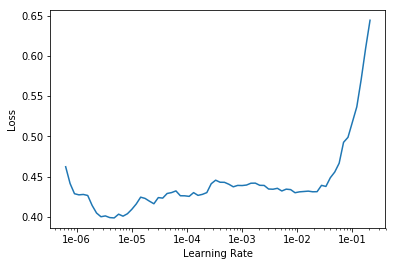

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
lr = 1e-2/2
learn.fit_one_cycle(10, slice(lr))

# epoch	train_loss	valid_loss	accuracy
# 1	0.418307	0.314684	0.880500
# 2	0.380213	0.281100	0.892500
# 3	0.379501	0.273085	0.894500
# 4	0.354433	0.280164	0.901500
# 5	0.322575	0.256971	0.903000
# 6	0.297976	0.241931	0.908000
# 7	0.276037	0.225358	0.917000
# 8	0.246060	0.217272	0.917000
# 9	0.233112	0.211983	0.920500
# 10	0.223878	0.213391	0.918500

epoch,train_loss,valid_loss,accuracy
1,0.418307,0.314684,0.880500
2,0.380213,0.281100,0.892500
3,0.379501,0.273085,0.894500
4,0.354433,0.280164,0.901500
5,0.322575,0.256971,0.903000
6,0.297976,0.241931,0.908000
7,0.276037,0.225358,0.917000
8,0.246060,0.217272,0.917000
9,0.233112,0.211983,0.920500
10,0.223878,0.213391,0.918500


In [17]:
learn.save("stage-1-resnet50-256")
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


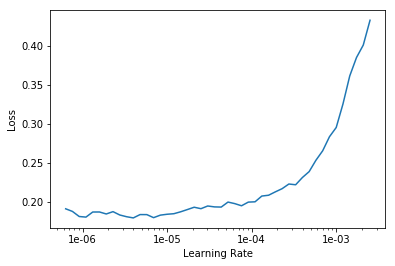

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(7, slice(1e-5, lr/10))

# epoch	train_loss	valid_loss	accuracy
# 1	0.239432	0.243699	0.907500
# 2	0.272414	0.263593	0.899000
# 3	0.265521	0.262773	0.907000
# 4	0.233356	0.245818	0.915500
# 5	0.183905	0.222679	0.924500
# 6	0.156239	0.219847	0.930500
# 7	0.132105	0.216870	0.931000

epoch,train_loss,valid_loss,accuracy
1,0.239432,0.243699,0.907500
2,0.272414,0.263593,0.899000
3,0.265521,0.262773,0.907000
4,0.233356,0.245818,0.915500
5,0.183905,0.222679,0.924500
6,0.156239,0.219847,0.930500
7,0.132105,0.216870,0.931000


In [26]:
learn.save("stage-2-resnet50-256")

In [ ]:
# ### OPTIONAL ###
# # Repeat above with larger image size - progressive resizing
# data = ImageDataBunch.from_name_re(path_img, 
#                                    fnames, 
#                                    pat, 
#                                    valid_pct=0.2, 
#                                    ds_tfms=tfms, 
#                                    size=512,        # using larger image size
#                                    bs=32)           # decreasing batch size
# data.normalize(imagenet_stats)

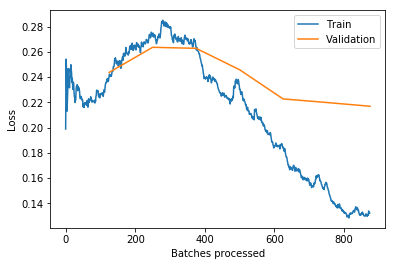

In [27]:
learn.recorder.plot_losses()

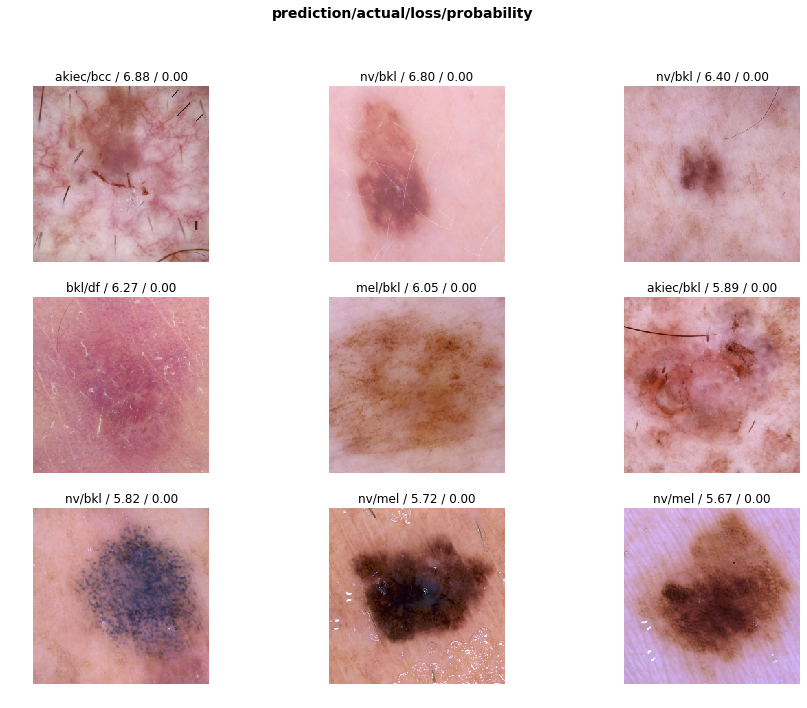

In [28]:
interp = ClassificationInterpretation.from_learner(learn)

# Predict top losses
interp.plot_top_losses(9, figsize=(15,11))
plt.savefig("pred_act_loss_prob.png")

[('mel', 'nv', 42),
 ('bkl', 'nv', 17),
 ('bkl', 'mel', 14),
 ('nv', 'mel', 13),
 ('mel', 'bkl', 12),
 ('akiec', 'bkl', 5),
 ('bkl', 'akiec', 4),
 ('df', 'nv', 3),
 ('mel', 'akiec', 3),
 ('nv', 'bcc', 3),
 ('nv', 'bkl', 3)]

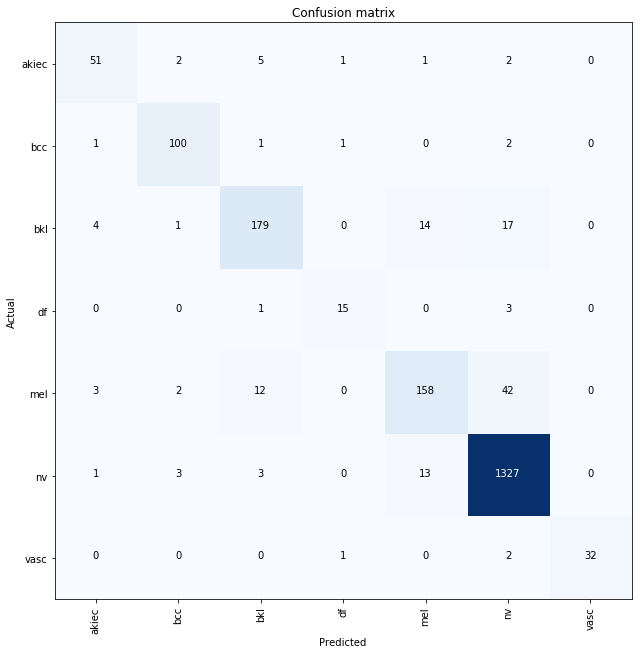

In [30]:
# Prediction and actual that was wrong most often
display(interp.most_confused(min_val=2))

# Confusion matrix
interp.plot_confusion_matrix(figsize=(9,9)) 

In [31]:
# Saves all information for inference eg. transforms, model weights
learn.export()

SyntaxError: invalid syntax (<ipython-input-1-c82f1c4b9e9e>, line 1)